In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
# Grab CIFAR10 Dataset
dataset = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose(
    [transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(256,512,4,2,1,bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        
        self.verify = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), 
            nn.Sigmoid()
        )
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, passedInput):
        passedInput = self.main(passedInput)
        validity = self.verify(passedInput)
        outputLabels = self.labels(passedInput)
        
        # resize
        validity = validity.view(-1)
        outputLabels = outputLabels.view(-1,11)
        return validity, outputLabels

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.emb = nn.Embedding(10,100)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,512,4,1,0,bias = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias = False),
            nn.Tanh()
        )
        
    def forward(self, noise, inputLabels):
        embLabels = self.emb(inputLabels)
        temp = torch.mul(noise, embLabels)
        temp = temp.view(-1, 100, 1, 1)
        return self.main(temp)

In [6]:
# Create Generator and Discriminator and apply initial weights
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_init)
generator.apply(weights_init)

Generator(
  (emb): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [7]:
# Setup optimizers 
disOptim = optim.Adam(discriminator.parameters(), 0.0002, betas = (0.5,0.999))
genOptim = optim.Adam(generator.parameters(), 0.0002, betas = (0.5,0.999))
criterion = nn.BCELoss()

# Parameters for training
numEpochs = 135
realLabelsTensor = 0.7 + 0.5 * torch.rand(10, device = device)
fakeLabelsTensor = 0.3 * torch.rand(10, device = device)

# Variables to track training progress
counterList = []
counter = 0
genLossList = []
disLossList = []

In [ ]:
# Training algorithm for discriminator and generator
for epoch in range(0, numEpochs):
    
    # Iterate through all batches
    for index, (data, imageLabels) in enumerate(dataloader, 0):
        counter += 1
        counterList.append(counter)
        
        # make data avaialbe for cuda
        data = data.to(device)
        imageLabels = imageLabels.to(device)
        sizeOfBatch = data.size(0)
        labelsReal = realLabelsTensor[index % 10]
        labelsFake = fakeLabelsTensor[index % 10]
        classLabelsFake = 10 * torch.ones((sizeOfBatch, ), dtype = torch.long, device = device)
        
        # Periodically switch labels
        if index % 25 == 0:
            temp = labelsReal
            labelsReal = labelsFake
            labelsFake = temp
        
        # Train Discriminator with real data
        labelsForValidate = torch.full((sizeOfBatch, ), labelsReal , device = device)
        disOptim.zero_grad() 
        validity, outputLabels = discriminator(data)       
        disRealValidError = criterion(validity, labelsForValidate)            
        disRealLabelError = F.nll_loss(outputLabels, imageLabels)
        disRealError = disRealValidError + disRealLabelError
        disRealError.backward()
        validMean1 = validity.mean().item()        
        
        # Train Discriminator with fake data
        disFakeLabels = torch.randint(0, 10, (sizeOfBatch, ), dtype = torch.long, device = device)
        noise = torch.randn(sizeOfBatch, 100, device = device)  
        labelsForValidate.fill_(labelsFake)
        fakeOutput = generator(noise, disFakeLabels)
        validity, outputLabels = discriminator(fakeOutput.detach())       
        disFakeValidError = criterion(validity, labelsForValidate)
        disFakeLabelError = F.nll_loss(outputLabels, classLabelsFake)
        disFakeError = disFakeValidError + disFakeLabelError
        disFakeError.backward()
        finalDisError = disRealError + disFakeError
        validMean2 = validity.mean().item()
        disOptim.step()
    
        # Train Generator
        labelsForValidate.fill_(1)
        labelsForGen = torch.randint(0, 10, (sizeOfBatch, ), device = device, dtype = torch.long)
        noise = torch.randn(sizeOfBatch, 100, device = device)  
        genOptim.zero_grad()
        fakeOutput = generator(noise, labelsForGen)
        validity, outputLabels = discriminator(fakeOutput)
        genValidError = criterion(validity, labelsForValidate)        
        genLabelError = F.nll_loss(outputLabels, labelsForGen)
        finalGenError = genValidError + genLabelError
        finalGenError.backward()
        validMean3 = validity.mean().item()
        genOptim.step()
        
        
        print("[{}/{}] [{}/{}] D(x): [{:.4f}] D(G): [{:.4f}/{:.4f}] GLoss: [{:.4f}] DLoss: [{:.4f}] DLabel: [{:.4f}] "
              .format(epoch, numEpochs, index, len(dataloader), validMean1, validMean2, validMean3, finalGenError, finalDisError,
                      disRealLabelError + disFakeLabelError + genLabelError))
        
        # Save errors for graphing
        disLossList.append(finalDisError.cpu().detach().numpy())
        genLossList.append(finalGenError.cpu().detach().numpy())
        
    # Save images to folder
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = generator(noise, labels)
    vutils.save_image(images.detach(),'acganOutput/fake_samples_epoch_%03d.png' % (epoch), normalize = True)

[0/135] [0/391] D(x): [0.4902] D(G): [0.6199/0.9574] GLoss: [6.9584] DLoss: [7.7656] DLabel: [13.4370] 
[0/135] [1/391] D(x): [0.6612] D(G): [0.9545/0.5730] GLoss: [7.4657] DLoss: [7.7474] DLabel: [10.8600] 
[0/135] [2/391] D(x): [0.4178] D(G): [0.6762/0.2250] GLoss: [8.2670] DLoss: [5.9776] DLabel: [10.3247] 
[0/135] [3/391] D(x): [0.5001] D(G): [0.5132/0.1235] GLoss: [9.0197] DLoss: [5.3001] DLabel: [10.1338] 
[0/135] [4/391] D(x): [0.5240] D(G): [0.5368/0.1731] GLoss: [9.3376] DLoss: [5.4536] DLabel: [11.0425] 
[0/135] [5/391] D(x): [0.6534] D(G): [0.6221/0.0339] GLoss: [10.9431] DLoss: [5.1401] DLabel: [10.1280] 
[0/135] [6/391] D(x): [0.4728] D(G): [0.3142/0.0253] GLoss: [11.6831] DLoss: [5.0377] DLabel: [11.0736] 
[0/135] [7/391] D(x): [0.5094] D(G): [0.3223/0.1641] GLoss: [10.2178] DLoss: [4.6858] DLabel: [11.3131] 
[0/135] [8/391] D(x): [0.6537] D(G): [0.7583/0.1073] GLoss: [10.9723] DLoss: [5.2223] DLabel: [11.6754] 
[0/135] [9/391] D(x): [0.6362] D(G): [0.6287/0.0235] GLoss: 

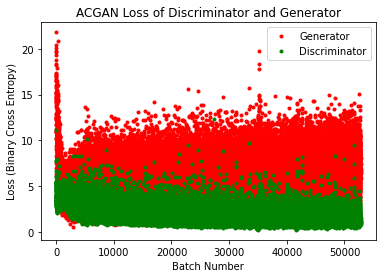

In [10]:
# Plot the loss of the generator and the descriminator
plt.plot(counterList, genLossList, 'r.', label='Generator')
plt.plot(counterList, disLossList, 'g.', label='Discriminator')
plt.title("ACGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Loss (Binary Cross Entropy)")
plt.legend(loc="best")
plt.show()